<a href="https://colab.research.google.com/github/AsmaBenHmidene/food-sales-predictions/blob/main/food_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
#imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

In [85]:
# Load data from file structure
filename = '/content/drive/MyDrive/Coding Dojo/ DATA SCIENCE FUNDAMENTALS/Week2/sales_predictions_2023 (1).csv'
df = pd.read_csv(filename)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Cleaning data:

In [86]:
df.shape

(8523, 12)

In [87]:
df.duplicated().sum()

0

no duplicates

In [88]:
df.nunique()

Item_Identifier              1559
Item_Weight                   415
Item_Fat_Content                5
Item_Visibility              7880
Item_Type                      16
Item_MRP                     5938
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     3
Outlet_Location_Type            3
Outlet_Type                     4
Item_Outlet_Sales            3493
dtype: int64

we will drop the 'Item_Identifier' column due to high cardinality, (1559 is a high number of unique labels).

In [89]:
df= df.drop(columns=['Item_Identifier'])
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [90]:
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

NaN value of Item_Weight will be replaced with the mean value.

NaN value of Outlet_Size will be replaced with the most frequent category.

In [91]:
df.select_dtypes('object').nunique()

Item_Fat_Content         5
Item_Type               16
Outlet_Identifier       10
Outlet_Size              3
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In [92]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [93]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF','Low Fat').replace('low fat','Low Fat').replace('reg','Regular')
df['Item_Fat_Content'].value_counts(normalize = True).mul(100).round(2)

Low Fat    64.73
Regular    35.27
Name: Item_Fat_Content, dtype: float64

In [94]:
df.describe().round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.00,8523.00,8523.00,8523.00,8523.00
mean,12.86,0.07,140.99,1997.83,2181.29
std,4.64,0.05,62.28,8.37,1706.50
min,4.56,0.00,31.29,1985.00,33.29
25%,8.77,0.03,93.83,1987.00,834.25
50%,12.60,0.05,143.01,1999.00,1794.33
75%,16.85,0.09,185.64,2004.00,3101.30
max,21.35,0.33,266.89,2009.00,13086.96


# Exploratory Visuals & Analysis:

## Numerical columns:

In [95]:
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [96]:
def plot_numeric(df,col):
  """EDA function to plot a histogram and boxplot for the selected column"""
  ## make the figure and axes sharing the same x-axis
  fig, axes = plt.subplots(nrows=2, figsize=(10,5), sharex=True)

  ## Use seaborn plots with ax=axes[i]
  sns.histplot(data=df,x = col,ax = axes[0])
  mean_value = df[col].mean()
  axes[0].axvline(mean_value,color='red', ls='--',
           label=f"Mean Value = ${mean_value:,.2f}",);

  med_value = df[col].median()
  axes[0].axvline(med_value,color='black', ls='--',
           label=f"Median Value = ${med_value:,.2f}");


  sns.boxplot(data=df, x = col, ax = axes[1])

  ## Updating title of top graph
  axes[0].set_title(f'EDA for {col}')

  ## Fixing any overlapping labels and showing
  plt.tight_layout()
  plt.show()

In [97]:
def plot_dist(data, col, title, figure_size=(10,5)):
  fig, ax = plt.subplots(figsize=figure_size)

  ## Plot histogram
  sns.histplot(data=data,x=col,ax=ax)
  ax.set_title(title);
  ax.set_ylabel('Count')
  ax.set_xlabel('Outlet Sales')
  ax.set_xlim(left=0,right=12000)
  ax.set_ylim(bottom=0,top=650)

  ## Annotating mean and median
  mean_price = data[col].mean()
  ax.axvline(mean_price,color='slategray', ls='--', lw=3, label=f"Mean= {mean_price:,.2f}");

  med_price = data[col].median()
  ax.axvline(med_price,color='skyblue', ls=':', lw=3, label=f"Median= {med_price:,.2f}");

  ax.legend();

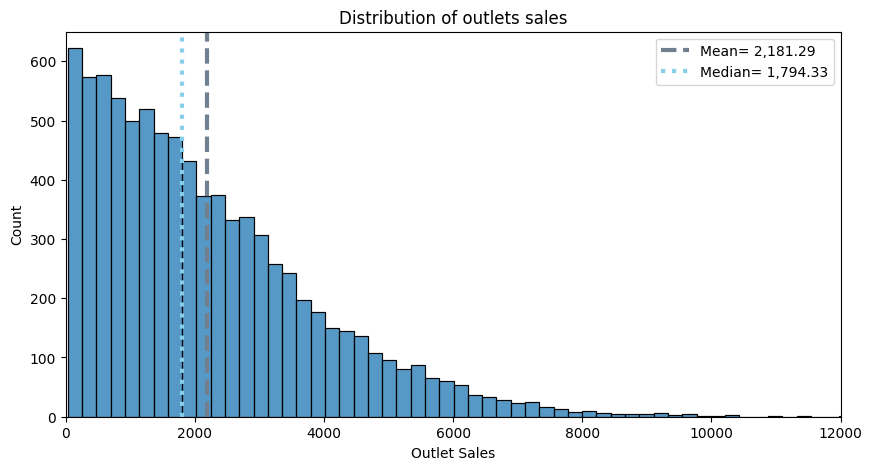

In [98]:
plot_dist(df, "Item_Outlet_Sales", "Distribution of outlets sales")

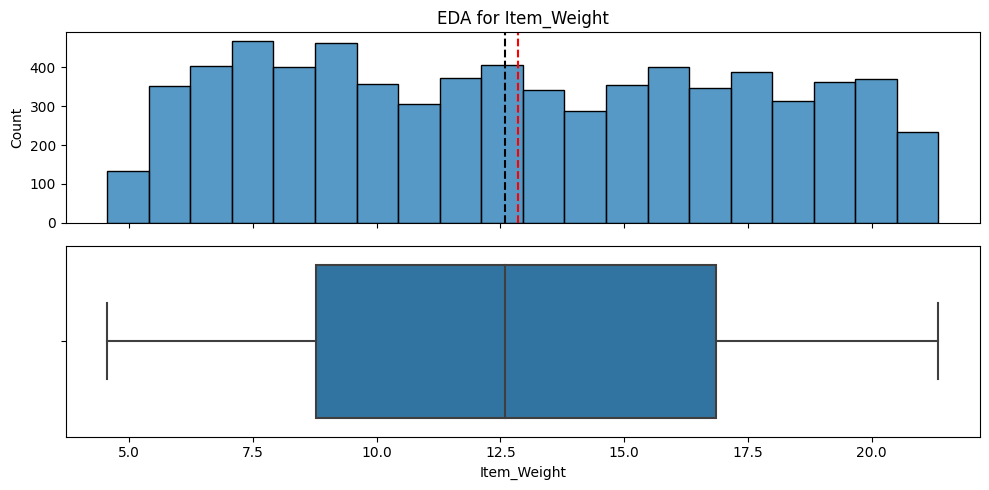

In [99]:
plot_numeric(df,'Item_Weight')

In [100]:
mean_price = df['Item_Weight'].mean()
print(f"Mean= {mean_price:,.2f}");

med_price = df['Item_Weight'].median()
print(f"Median= {med_price:,.2f}");

Mean= 12.86
Median= 12.60


Item_Weight column contains NaN values. we will impute them with the mean value.

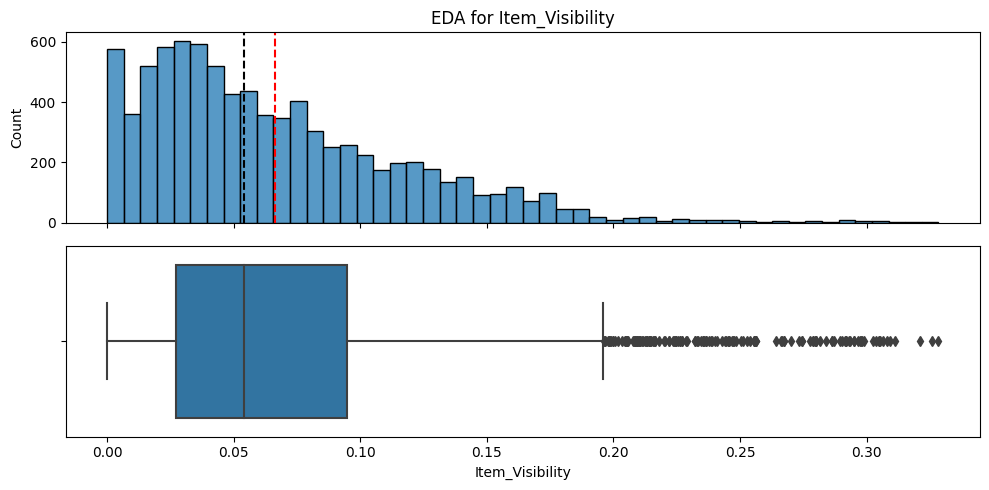

In [101]:
plot_numeric(df,'Item_Visibility')

In [102]:
mean_price = df['Item_Visibility'].mean()
print(f"Mean= {mean_price:,.2f}");

med_price = df['Item_Visibility'].median()
print(f"Median= {med_price:,.2f}");

Mean= 0.07
Median= 0.05


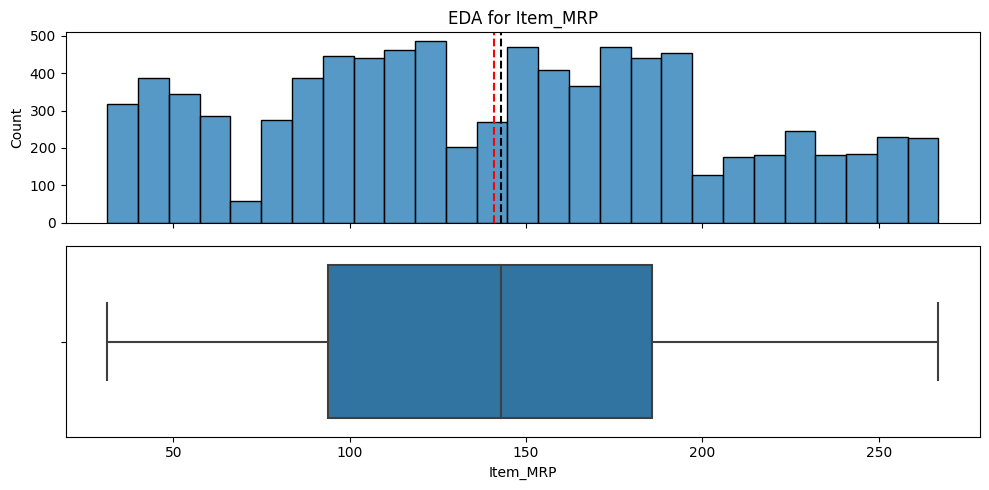

In [103]:
plot_numeric(df,'Item_MRP')

In [104]:
mean_price = df['Item_MRP'].mean()
print(f"Mean= {mean_price:,.2f}");

med_price = df['Item_MRP'].median()
print(f"Median= {med_price:,.2f}");

Mean= 140.99
Median= 143.01


## Categorical columns:

In [105]:
## functionize a barplot and call it plot_bar

def plot_bar(data,x, y, figsize=(10,5)):
    ## Make a larger fig/ax before plotting
    fig, ax = plt.subplots(figsize=figsize)

    ## Plot barplot

    ## counts, counts up the categories, sort the values, then puts them in a
    ## data frame.

    counts = df[x].value_counts().sort_values(ascending=False).to_frame()
    ## ploting the barplot

    sns.barplot(data=counts,x=counts.index, y = counts[x],ax=ax)

    plt.xticks(rotation= 90)
    ax.set_title(f'Categorical Frequencies of {y}', fontsize = 20, fontweight = 'bold');
    ax.set_xlabel(f'Categories for {y}', fontsize = 15, fontweight = 'bold')
    ax.set_ylabel('Counts', fontsize = 15, fontweight = 'bold')

    return fig,ax


In [106]:
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


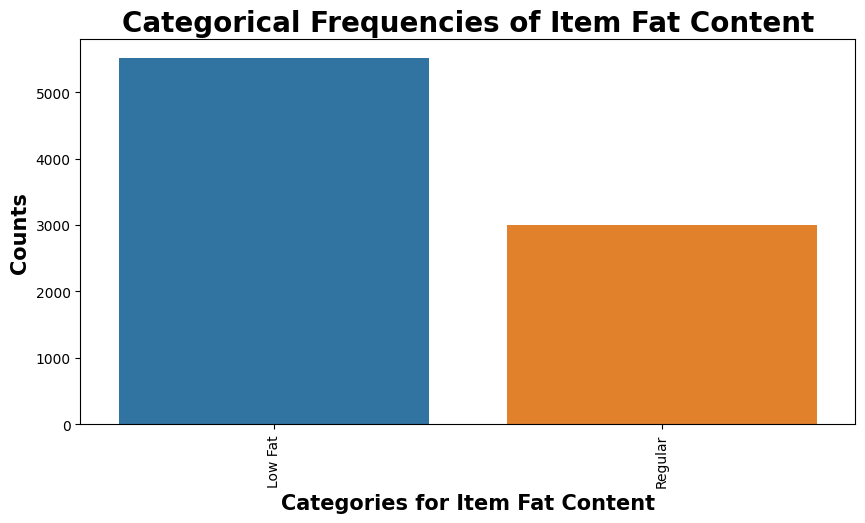

In [107]:
fig, ax = plot_bar(df, 'Item_Fat_Content', 'Item Fat Content');
print(df['Item_Fat_Content'].value_counts())

Most of the products are classified as low fat items.

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


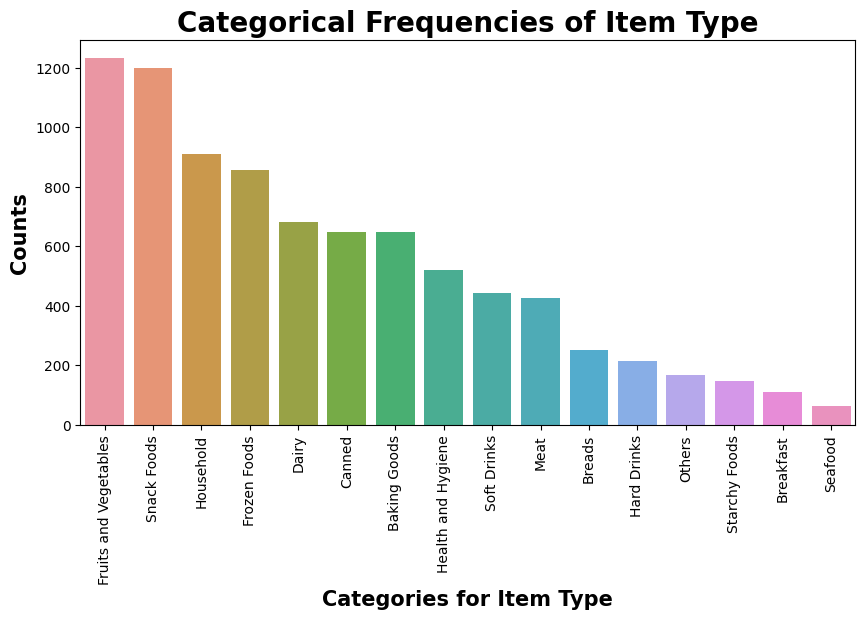

In [108]:
fig, ax = plot_bar(df, 'Item_Type', 'Item Type');
print(df['Item_Type'].value_counts())

Fruits and vegetables are the main products offered for sales in the outlets, while seafood are the least frequent one.

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


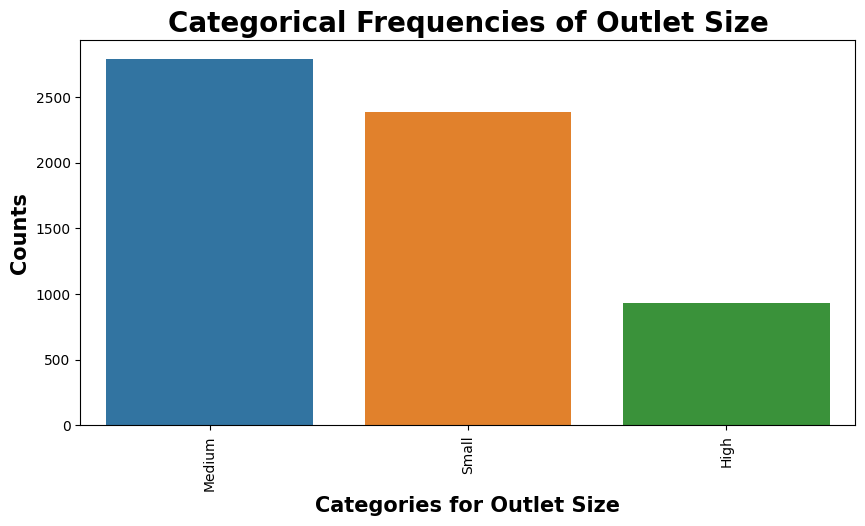

In [109]:
fig, ax = plot_bar(df, 'Outlet_Size', 'Outlet Size');
print(df['Outlet_Size'].value_counts())

Most of the outlets have a medium size.

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


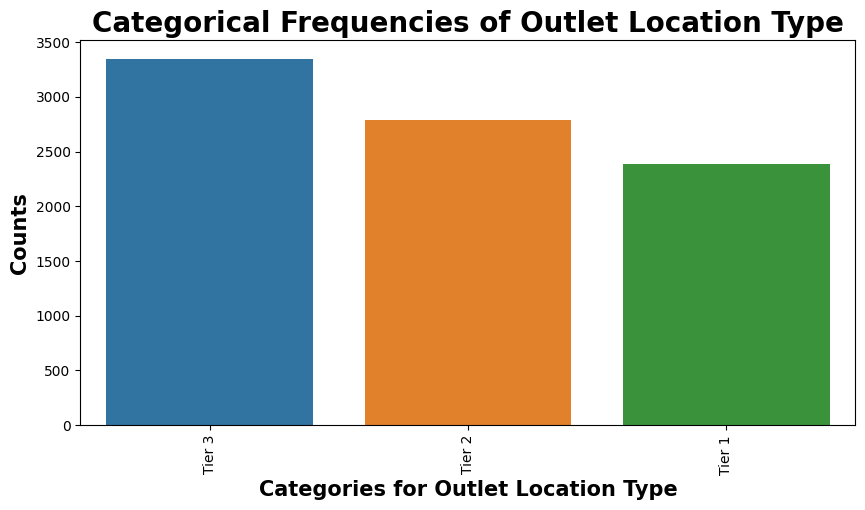

In [110]:
fig, ax = plot_bar(df, 'Outlet_Location_Type', 'Outlet Location Type');
print(df['Outlet_Location_Type'].value_counts())

Most of the outlets are located in Tier 3 location type.

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64


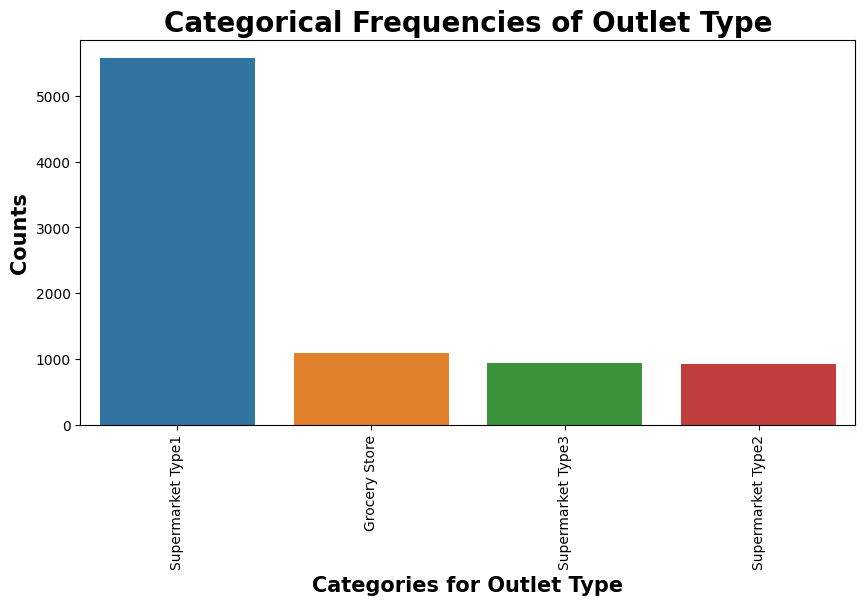

In [111]:
fig, ax = plot_bar(df, 'Outlet_Type', 'Outlet Type');
print(df['Outlet_Type'].value_counts())

Supermarket Type 1 represent the main market category.

Analyse the relation between Item Outlet Sales and Item Type/Item Fat Content:

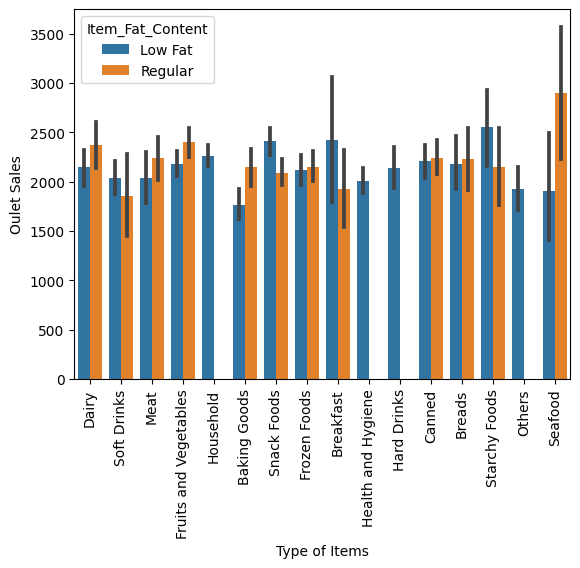

In [112]:
sns.barplot(data=df, x='Item_Type', y="Item_Outlet_Sales", hue='Item_Fat_Content');
plt.ylabel('Oulet Sales')
plt.xlabel('Type of Items')
plt.xticks(rotation = 90);

Regular products represent the principle sales and more specifically seafood. Fruits and vegetables come in the second position even though they represent the main products offered for sales. For Low fat item, starchy foods represent the most selled product.

Analyse the relation between Item Outlet Sales and Outlet_Type:

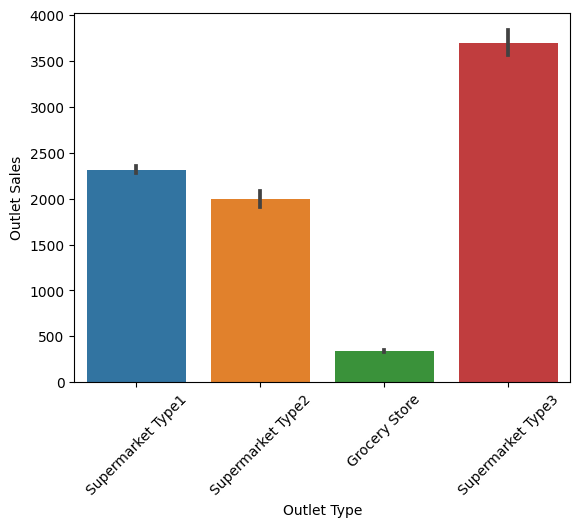

In [113]:
sns.barplot(data=df, x='Outlet_Type', y="Item_Outlet_Sales");
plt.xticks(rotation = 45);
plt.ylabel('Outlet Sales')
plt.xlabel('Outlet Type');

Supermarket Type3 shows the highest sales average (3700). Supermarket Type 1 come in the second position (2400 sales' average) even though they are the main type among all outlets.

Analyse the relation between Item Outlet Sales and Outlet location type:

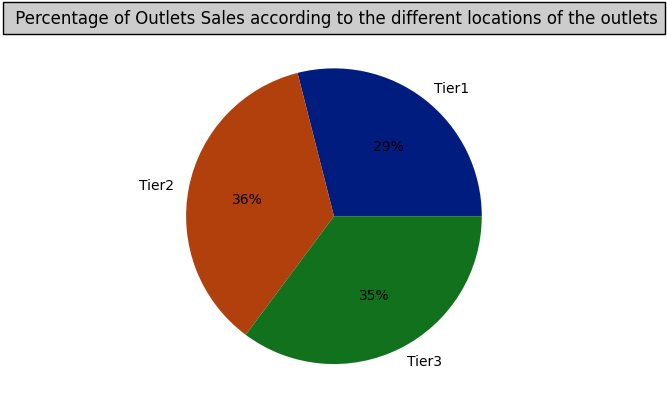

In [114]:
data=df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().round(2)
labels = ['Tier1', 'Tier2', 'Tier3']
colors = sns.color_palette('dark')[0:5]
plt.pie( data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title(" Percentage of Outlets Sales according to the different locations of the outlets", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

Outlets in location Tier 3 and Tier 2 show the highest sales percentage.

Analyse the relation between Item Outlet Sales and Outlet Size:

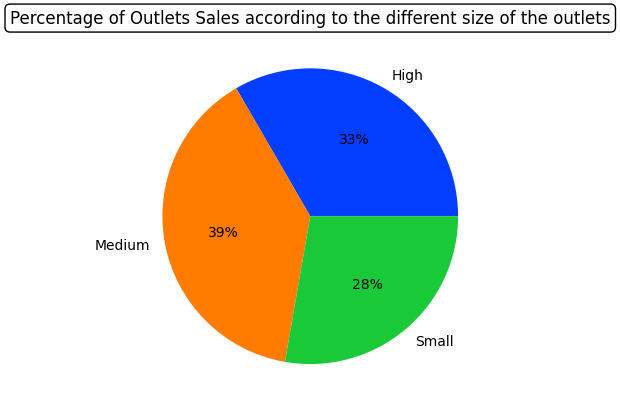

In [115]:
data=df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().round(2)
labels = ['High', 'Medium', 'Small']
colors = sns.color_palette('bright')[0:5]
plt.pie( data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Percentage of Outlets Sales according to the different size of the outlets", bbox={'facecolor':'none', 'edgecolor':'black', 'boxstyle':'round', 'pad': 0.3})
plt.show()

Most sales are done in medium size outlets. Outlet_Size column contains NaN value, we will impute them with the most frequent category which is 'Medium'.

Analyse the relation between Item Outlet Sales and Item MRP:

In [116]:
corr = df.corr()

<ipython-input-116-45893e33df67>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


(<Axes: >,)

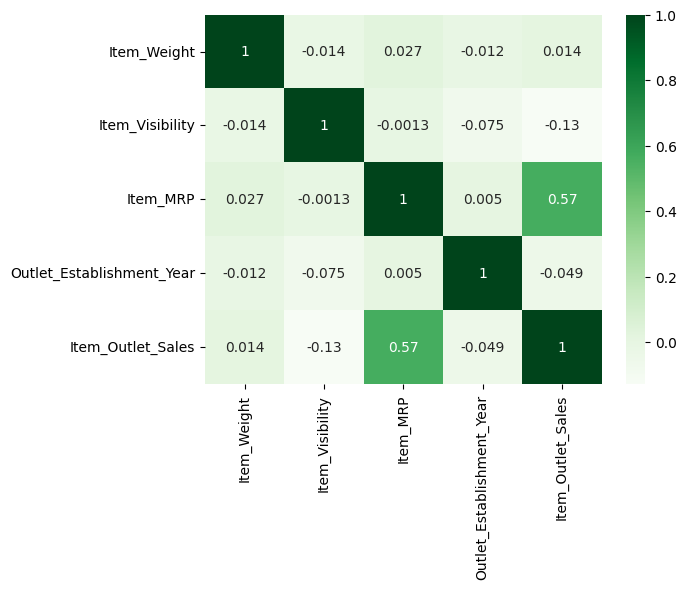

In [117]:
sns.heatmap(corr, cmap = 'Greens', annot = True),

There is a moderate correlation between Item Outlet sales and Item MRP(r=0.57).

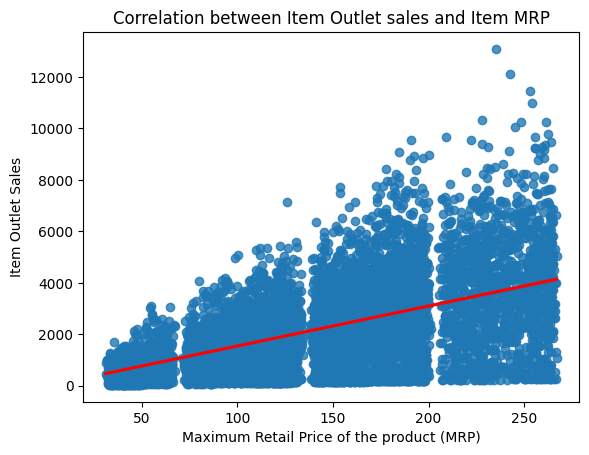

In [118]:
sns.regplot(data=df, x='Item_MRP', y='Item_Outlet_Sales',line_kws = dict(color='red', ls='solid'));
plt.title("Correlation between Item Outlet sales and Item MRP")
plt.xlabel('Maximum Retail Price of the product (MRP)')
plt.ylabel('Item Outlet Sales');

The scatterplot correlating Item outlet sales with item MRP shows 4 groups. Items with MRP between 20 and 70 (group 1) show the lowest sales average, followed by Items with MRP between 80 and 140 (group 2), then Items with MRP between 140 and 200 (group 3) and finally Items with sales between 210 and 270 (group 4) that represent the highest items'sales .

There are a positive correlation between the outlet sales and MRP. The sales increase whith the increase of the MRP of the product.

# Pre-processing:

In [119]:
#Identify the features (X) and target (y)
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales'])

In [120]:
#Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,OUT035,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,OUT045,2002,NaN,Tier 2,Supermarket Type1


In [121]:
#Create list of column names for numeric columns
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_mean, scaler)
num_pipe

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [122]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

In [123]:
# Save list of column names
nomi_cols = X_train.select_dtypes('object').drop(columns= ['Outlet_Size']).columns
print("Nominal OneHotEncoder Columns:", nomi_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "MISSING")
nomi_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
nomi_pipe = make_pipeline(impute_na, nomi_encoder)
nomi_pipe

Nominal OneHotEncoder Columns: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [124]:
# Making a ohe_tuple for ColumnTransformer
nomi_tuple = ('nomi categorical', nomi_pipe, nomi_cols)
nomi_tuple

('nomi categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

In [125]:
# Defining lists of ordinal features
ord_cols = ['Outlet_Size']
# Specifying the order of categories in quality/condition columns
impute_na_ord = SimpleImputer(strategy= 'most_frequent')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
qual_cond_order = ['High','Medium','Small']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [qual_cond_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
# Instantiate the Pipeline
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['High', 'Medium', 'Small']])),
                ('standardscaler', StandardScaler())])

In [126]:
# Making a ohe_tuple for ColumnTransformer
ord_tuple = ('ord categorical', ord_pipe, ord_cols)
ord_tuple

('ord categorical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['High', 'Medium', 'Small']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

In [127]:
#Instantiate the ColumnTransformer
col_transformer = ColumnTransformer([num_tuple, nomi_tuple, ord_tuple],verbose_feature_names_out=False)

In [128]:
#Fit the Transformer on Training Data Only
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('nomi categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencode...
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')),
                                ('ord categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['High',
                                                                              'Medium',
                                                                              'Small']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size'])],
                  verbose_feature_names_out=False)

In [129]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# View the processed training data
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size
4776,0.817249,-0.712775,1.828109,1.327849,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.287374
7510,0.556340,-1.291052,0.603369,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.287374
5828,-0.131512,1.813319,0.244541,0.136187,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.287374
5327,-1.169219,-1.004931,-0.952591,0.732018,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.384048
4810,1.528819,-0.965484,-0.336460,0.493686,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.287374


# 1. linear regression model to predict sales:

- Build a linear regression model.
- Evaluate the performance of your model based on r^2.
- Evaluate the performance of your model based on rmse.

In [130]:
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [131]:
lin_reg.fit(X_train_processed, y_train)

LinearRegression()

In [132]:
# Get predictions for the training data
y_predictions_train = lin_reg.predict(X_train_processed)
# Get predictions for the testing data
y_predictions_test = lin_reg.predict(X_test_processed)

In [133]:
# Saving a copy of X_test_tf and adding the true and predicted price and the error
prediction_df = X_test_processed.copy()
prediction_df['True Item_Outlet_Sales'] = y_test
prediction_df['Predicted Item_Outlet_Sales'] = y_predictions_test.round(1)
prediction_df['Error'] = (y_predictions_test - y_test).round(1)
prediction_df.head(10)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,True Item_Outlet_Sales,Predicted Item_Outlet_Sales,Error
7503,3.310089e-01,-0.776646,-0.998816,-1.293807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,-1.958796,1743.0644,1360.6,-382.5
2957,-1.179892e+00,0.100317,-1.585194,-0.102145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.384048,356.8688,717.5,360.6
7031,3.784469e-01,-0.482994,-1.595784,0.136187,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.287374,377.5086,881.6,504.0
1084,4.213344e-16,-0.415440,0.506592,-1.532139,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.287374,5778.4782,4235.4,-1543.1
856,-6.426567e-01,-1.047426,0.886725,0.732018,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.384048,2356.9320,3342.3,985.3
4304,-8.075039e-01,-0.470511,-1.748367,0.136187,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.287374,865.5400,611.2,-254.3
2132,4.213344e-16,1.189692,1.070615,-1.532139,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.287374,4613.9940,4760.3,146.4
1385,-5.703138e-01,-1.025995,0.000559,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.287374,2410.8618,2064.6,-346.3
5239,2.598518e-01,-0.824923,-0.620321,1.327849,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.287374,1948.1308,1401.6,-546.6
6516,-1.042322e+00,-0.974654,0.801084,1.327849,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.287374,1937.4780,2820.3,882.8


- Evaluate the performance of your model based on r^2:

In [134]:
train_r2 = r2_score(y_train, y_predictions_train)
test_r2 = r2_score(y_test, y_predictions_test)
print(f'Training R2: {train_r2:.3f}')
print(f'Testing R2: {test_r2:.3f}')

Training R2: 0.562
Testing R2: 0.567


- Evaluate the performance of your model based on rmse:

In [135]:
train_RMSE = mean_squared_error(y_train,  y_predictions_train, squared=False)
test_RMSE = mean_squared_error(y_test, y_predictions_test, squared=False)
print(f'Training RMSE: {train_RMSE:,.2f}')
print(f'Testing RMSE: {test_RMSE:,.2f}')

Training RMSE: 1,139.10
Testing RMSE: 1,092.86


# 2. Regression tree model to predict sales:

- Build a simple regression tree model.
- Compare the performance of your model based on r^2.
- Compare the performance of your model based on rmse.

In [136]:
# Instatiate Default model
dec_tree = DecisionTreeRegressor(random_state = 42)

# Fit default model on training data only
dec_tree.fit(X_train_processed, y_train)

# Make predictions for training and testing data
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

- Compare the performance of your model based on r^2:

In [137]:
train_score = r2_score(y_train, train_preds)
test_score = r2_score(y_test, test_preds)
print(f' The training r2 is: {train_score.round(3)}.')
print(f' The testing r2 is: {test_score.round(3)}.')

 The training r2 is: 1.0.
 The testing r2 is: 0.176.


- Compare the performance of your model based on rmse.

In [138]:
train_RMSE = mean_squared_error(y_train,  train_preds, squared=False)
test_RMSE = mean_squared_error(y_test, test_preds, squared=False)
print(f'Training RMSE: {train_RMSE:,.2f}')
print(f'Testing RMSE: {test_RMSE:,.2f}')

Training RMSE: 0.00
Testing RMSE: 1,507.47


# which model to implement:
- Overall, which model do you recommend?
- Justify your recommendation.

#In case of the linear regression model:

- Coefficient of Determination/R2: The model performs almost equally on the training data and the test data (R2 0.562 for training data vs. 0.567 for test data).
- Root Mean Squared Error (RMSE) Interpretation: On average, our model is incorrect by about 1.1 thousand dollars, almost the same error value predected with the training data (This metric penalizes larger errors).

This model represent a good balance between the training data and testing data prediction.

#In case of the regression tree model:

- Coefficient of Determination/R2: The model performs much more better on the training data (R2 1.0. for training data vs. 0.176 for test data).
- Root Mean Squared Error (RMSE) Interpretation: On average, our model is incorrect by about 1.5 thousand dollars, while the error value predicted with the training data is equal to 0.00 .

This model is overfited, it makes good predictions on a training set, but poor predictions on a testing set.

Taking into consideration that the regression tree model is an overfit model, we recommend for this project to use the linear regression model.

# Final recommendations:

The properties of products and and outlets that play crucial roles in increasing sales are as follow:

 1. Outlet types:
 - since Supermarket Type3 shows the highest sales average (3700), it will be recommended to increase the number of this type of supermarket instead of Supermarket Type 1 which represent the main type among all outlets(65%).


 2. Outlet location types:
 - Outlets in location Tier 3 and Tier 2 show the highest sales percentage.


 3. Outlet size:
 - Most sales are done in medium size outlets.
    

 4. Properties of products:
 - Regular products represent the principle sales and more specifically seafood. Fruits and vegetables come in the second position even though they represent the main products offered for sales in the outlets. Those products are essentials for daily food consumption
 - For Low fat item, starchy foods represent the most selled product.

 - Fruits and vegetables, seafood and starchy foods are essentials products for daily food consumption, which explain why they represent the main sales in the outlets. It is recommended to increase the quantity of seafood presented for sales because according to data, seafood are the least frequent item in all outlets.


 5. From the correlation between outlets sales and MRP of product, we can conclude that Items with MRP between 140 and 270 represent the highest items'sales. It is recommended to increase the visibity of those products to increase outlets sales.


 6. Model Performance: Overall, the best model is definitely the linear regression model, by far it outperformed the regression tree model.